# Bonus: Pyomo.DoE with Four State Model

In this notebook, you will use Pyomo.DoE to compute the A- and D-optimal experiments from the TCLab considering the four state model for the TC Lab.

Recall, we can computing the next best experiment assuming we already completed one prior experiment. Thus it is important to confirm our optimal experiment design does not change if we change the prior experiment of optimization initial point.

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 4

## Load and explore experimental data (step test)

We will load the step test experimental data, similar to our previous notebooks.

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv"
else:
    file = '../data/tclab_sine_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


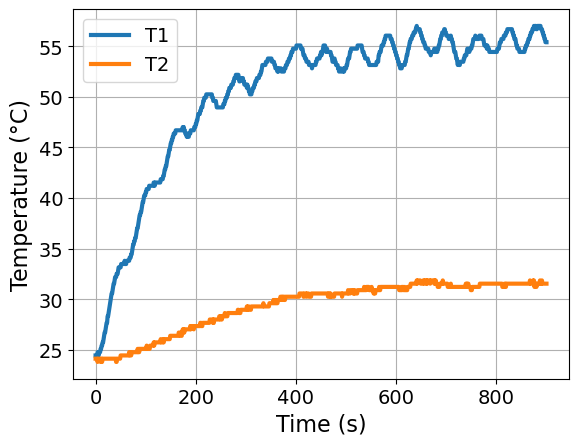

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')
ax.grid(True)

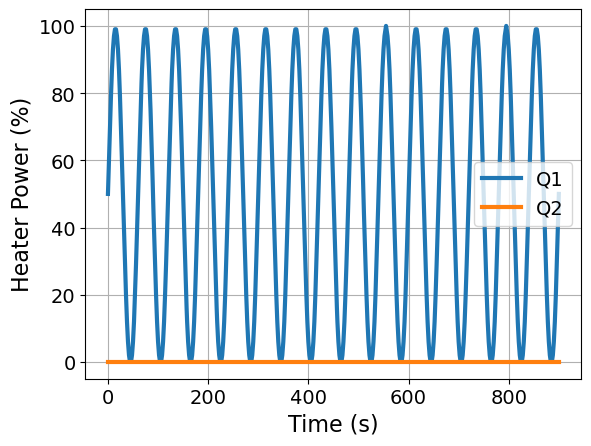

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')
ax.grid(True)

In [5]:
tc_data = TCLabExperiment(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Analyze FIM with Pyomo.DoE at initial point (step test)

To get started, compute and analyze the FIM of the step test experiment.

In [6]:
# Load Pyomo.DoE functions
from pyomo.contrib.doe import (
    ModelOptionLib,
    DesignOfExperiments,
    MeasurementVariables,
    DesignVariables,
)

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {
    'Ua': 0.0406328703006202, 
    'Ub': 0.0004788908684868069, 
    'Uc': 0.014287092203588921, 
    'inv_CpH': 0.15644842098642808, 
    'inv_CpS': 99.99999924789579}

In [7]:
# Get time points for control decisions
t_control = tc_data.time

# Define the measurement variables
measurements = MeasurementVariables()
measurements.add_variables(
    'Ts1', 
    indices={0: t_control}, 
    time_index_position=0)

In [8]:
# Define the design variables
decisions = DesignVariables()

decisions.add_variables(
    'U1',
    indices={0: t_control},
    time_index_position=0,
    lower_bounds=0,
    upper_bounds=100,
    values=tc_data.u1,
)

In [9]:
# Define create_model function for Pyomo.DoE

def create_model_doe(theta=theta_values):
    return create_model(
        data=tc_data,
        mode='doe',
        theta=theta,
        integrate_to_initialize=True,
        number_of_states=number_tclab_states,
    )


In [10]:
# Create doe_object using DesignOfExperiments

doe_object1 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=SolverFactory('ipopt'),
)

# Compute and print the FIM at this point
result = doe_object1.compute_FIM(mode='sequential_finite', formula='central')
result.result_analysis()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [11]:
# Call our custom function to summarize the results
# and compute the eigendecomposition of the FIM

results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 13.073354277366219
D-optimality: 29.03519932787332
E-optimality: -5.400229174506027
Modified E-optimality: 18.47351685980527

FIM:
 [[ 5.95181328e+08 -8.08565300e+10  1.78115723e+09  2.01473847e+08
  -3.85581372e+05]
 [-8.08565300e+10  1.18334781e+13 -2.21941285e+11 -2.68730852e+10
   5.64007732e+07]
 [ 1.78115723e+09 -2.21941285e+11  5.92788883e+09  6.19028759e+08
  -1.05925880e+06]
 [ 2.01473847e+08 -2.68730852e+10  6.19028759e+08  6.90758687e+07
  -1.28171949e+05]
 [-3.85581372e+05  5.64007732e+07 -1.05925880e+06 -1.28171949e+05
   2.68818852e+02]]

eigenvalues:
 [1.18382549e+13 1.81184981e+09 3.08301756e+06 4.12137963e+05
 3.97897147e-06]

eigenvectors:
 [[ 6.83193110e-03  1.48117724e-01 -9.62523741e-01 -2.27073804e-01
  -3.58838605e-06]
 [-9.99798197e-01  1.96667099e-02 -4.09555672e-03  1.07923133e-04
  -4.76981426e-06]
 [ 1.87545587e-02  9.86679033e-01  1.58900260e-01 -2.93846748e-02
   1.63360998e-06]


**Discussion:** How does this FIM compare to the sine test experiment we [previously analyzed](../notebooks/doe_exploratory_analysis.ipynb)?

## Optimize the next experiment (A-optimality)

Now we are ready to compute the A-optimal next best experiment. Why are we starting with A-optimality? It runs faster so it is better for debugging syntax.

In [13]:
# Extract the prior FIM and Jacobian information from the previous
# result to use for initialization.
prior = result.FIM.copy()
jac_for_initialization = result.jaco_information.copy()

# Set Ipopt options
solver = SolverFactory('ipopt')
# solver.options['bound_push'] = 1E-10
solver.options['halt_on_ampl_error'] = 'yes'
solver.options['tol'] = 1E-5
solver.options['acceptable_tol'] = 1E-4
solver.options['max_iter'] = 55
solver.options['linear_solver'] = 'ma57'

# Create a new DoE object
doe_object3 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=solver,
    prior_FIM=prior,  # use previous experiment as prior
)

# Solve the DoE problem
square_result3, optimize_result3 = doe_object3.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=False,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="trace",  # objective option (need to debug/improve initialization)
    jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
    step=0.01,  # step size
)

Ipopt 3.13.2: halt_on_ampl_error=yes
tol=1e-05
acceptable_tol=0.0001
max_iter=55
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

In [ ]:
from idaes.core.util.model_diagnostics import DiagnosticsToolbox

future: the set contained only NumericConstant and _PythonCallbackFunctionID,
and provided no meaningful value to clients or walkers.  Users should likely
handle these types in the same manner as immutable Params.  (deprecated in
6.7.2) (called from <frozen importlib._bootstrap>:241)
'_BlockData'.  The class '_BlockData' has been renamed to 'BlockData'.
(deprecated in 6.7.2) (called from
/Users/adowling/anaconda3/envs/summer2024/lib/python3.10/site-
packages/idaes/core/base/process_base.py:78)
from '_GeneralExpressionData'.  The class '_GeneralExpressionData' has been
renamed to 'ExpressionData'.  (deprecated in 6.7.2) (called from
/Users/adowling/anaconda3/envs/summer2024/lib/python3.10/site-
packages/idaes/core/base/var_like_expression.py:31)


In [ ]:
dt = DiagnosticsToolbox(optimize_result3.model, constraint_residual_tolerance=1E-8)
dt.display_constraints_with_large_residuals()

The following constraint(s) have large residuals (>1.0E-08):




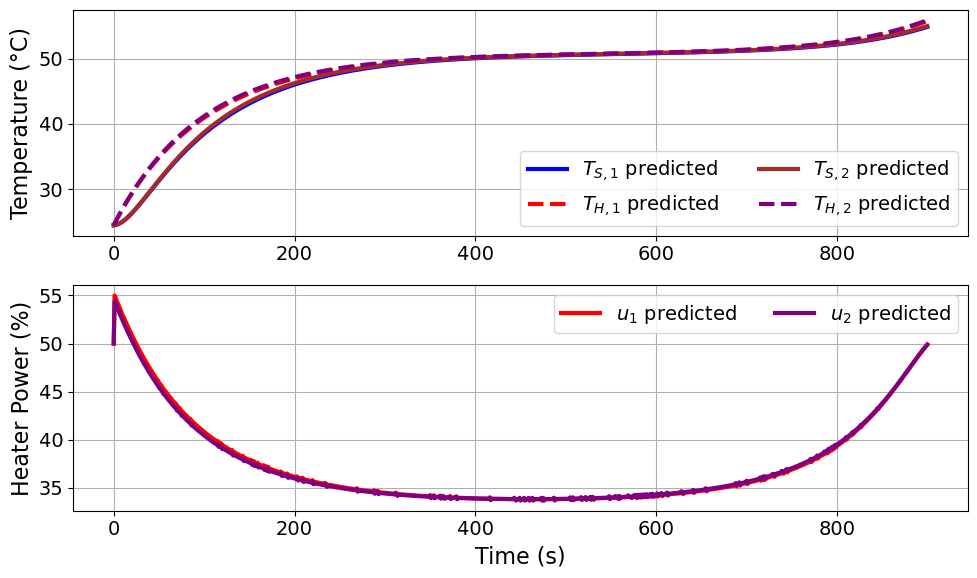

Model parameters:
Ua = 0.0406 Watts/degC
Ub = 0.0005 Watts/degC
Uc = 0.0143 Watts/degC
CpH = 6.3919 Joules/degC
CpS = 0.01 Joules/degC
 


In [14]:
# Extract and plot the results using our custom function
aopt_pyomo_doe_results = extract_plot_results(None, optimize_result3.model)

In [15]:
# Compute the FIM at the optimal solution
optimize_result3.result_analysis()
results_summary(optimize_result3)

======Results Summary======
Four design criteria log10() value:
A-optimality: 13.07335428053186
D-optimality: 37.51848694742201
E-optimality: 3.0512276168723917
Modified E-optimality: 10.022060068469829

FIM:
 [[ 5.95250150e+08 -8.08565320e+10  1.78115763e+09  2.01462256e+08
  -3.87556461e+05]
 [-8.08565320e+10  1.18334781e+13 -2.21941285e+11 -2.68730815e+10
   5.64019322e+07]
 [ 1.78115763e+09 -2.21941285e+11  5.92788885e+09  6.19028200e+08
  -1.05939102e+06]
 [ 2.01462256e+08 -2.68730815e+10  6.19028200e+08  6.90910117e+07
  -1.24437674e+05]
 [-3.87556461e+05  5.64019322e+07 -1.05939102e+06 -1.24437674e+05
   1.43276364e+03]]

eigenvalues:
 [1.18382549e+13 1.81185122e+09 3.14269435e+06 4.35057808e+05
 1.12519454e+03]

eigenvectors:
 [[ 6.83193130e-03  1.48123027e-01  9.64334269e-01  2.19240945e-01
   2.39144914e-03]
 [-9.99798197e-01  1.96667305e-02  4.09444750e-03 -1.41159300e-04
  -4.67715937e-06]
 [ 1.87545587e-02  9.86678284e-01 -1.58661528e-01  3.06707445e-02
   2.35088827e-04]


**Discussion:** How do these compare to our [previous A-optimal results](../notebooks/doe_optimize.ipynb) considering the sine test as the prior experiment?

## Optimize the next experiment (D-optimality)

Finally, we are ready to solve the D-optimality problem. This may take 2 minutes to run.

In [17]:
solver.options['max_iter'] = 500

# Create a new DoE object
doe_object2 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=solver,
    prior_FIM=prior,  # use previous experiment as prior
)

# Solve the DoE problem
square_result2, optimize_result2 = doe_object2.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=True,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="det",  # objective option (need to debug/improve initialization)
    jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
    step=0.01,  # step size
)

Ipopt 3.13.2: halt_on_ampl_error=yes
tol=1e-05
acceptable_tol=0.0001
max_iter=500
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a 

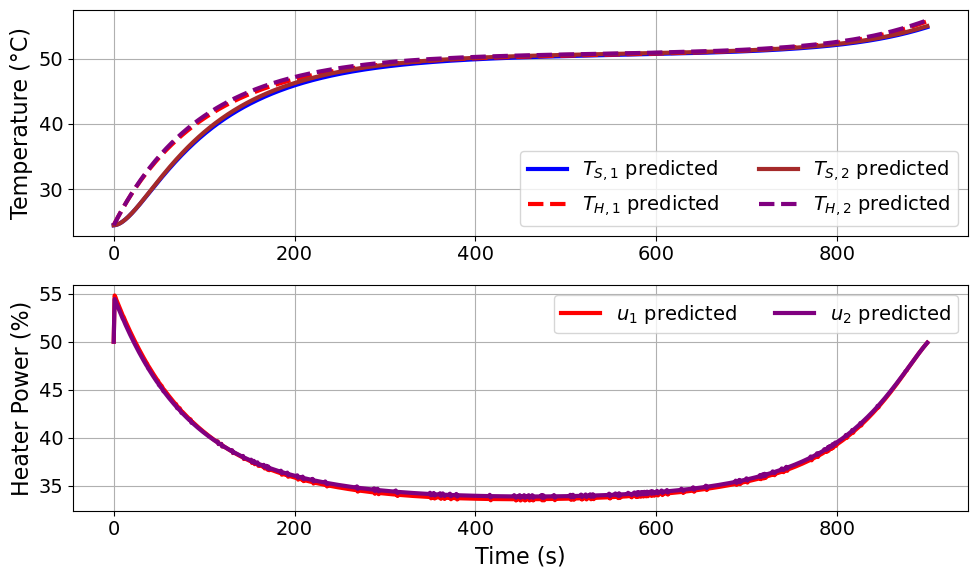

Model parameters:
Ua = 0.0406 Watts/degC
Ub = 0.0005 Watts/degC
Uc = 0.0143 Watts/degC
CpH = 6.3919 Joules/degC
CpS = 0.01 Joules/degC
 


In [18]:
# Extract and plot the results using our custom function
dopt_pyomo_doe_results = extract_plot_results(None, optimize_result2.model)

In [19]:
# Compute the FIM at the optimal solution
optimize_result2.result_analysis()
results_summary(optimize_result2)

======Results Summary======
Four design criteria log10() value:
A-optimality: 13.073356768647201
D-optimality: 42.3138320545039
E-optimality: 5.660453649673805
Modified E-optimality: 7.412834035678904

FIM:
 [[ 5.95549837e+08 -8.08565364e+10  1.78115836e+09  2.01058748e+08
   4.50180970e+06]
 [-8.08565364e+10  1.18334781e+13 -2.21941285e+11 -2.68730719e+10
   5.63195224e+07]
 [ 1.78115836e+09 -2.21941285e+11  5.92788886e+09  6.19026147e+08
  -1.04296706e+06]
 [ 2.01058748e+08 -2.68730719e+10  6.19026147e+08  6.96375258e+07
  -5.94436911e+06]
 [ 4.50180970e+06  5.63195224e+07 -1.04296706e+06 -5.94436911e+06
   6.69880650e+07]]

eigenvalues:
 [1.18382549e+13 1.81185241e+09 6.78601416e+07 3.09280928e+06
 4.57565898e+05]

eigenvectors:
 [[-6.83193177e-03  1.48134028e-01 -7.41068350e-02  9.58180711e-01
   2.33254231e-01]
 [ 9.99798197e-01  1.96667572e-02 -1.98016016e-04  4.09126957e-03
  -7.55091677e-05]
 [-1.87545587e-02  9.86677608e-01  5.68455095e-03 -1.59054225e-01
   2.80179065e-02]
 [

**Discussion:** How do these results compare to [our previous analysis](../notebooks/doe_exercise.ipynb)?